# ST456: Deep Learning, Assignment 2
## Candidate Number: 50270

In [1]:
from google.colab import drive
drive.mount("/base")

Mounted at /base


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

## Data Preparation

In [3]:
batch_size = 128
num_classes = 8
n_epochs = 50

train_dataset = tf.data.Dataset.load("/base/MyDrive/Assignment2_DL/ST456_assignment2/assign2_train")
val_dataset = tf.data.Dataset.load("/base/MyDrive/Assignment2_DL/ST456_assignment2/assign2_val")

train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

In [ ]:
# 3D tensor: time, frequency, intensity of a song segment
for sample in train_dataset.take(1):
    spectrogram, label = sample
    print("Spectrogram shape:", spectrogram.shape)
    print("Label shape:", label.shape)
    print("Label example:", label.numpy())

Spectrogram shape: (80, 80, 1)
Label shape: (8,)
Label example: [1. 0. 0. 0. 0. 0. 0. 0.]


**Tensor dimensions: (80, 80, 1)**

**Note: Since the label is 1-hot encoded we will use categorical cross-entropy as our loss function instead of sparse categorical cross-entropy.** This is because sparse categorical cross-entropy requires the labels to contain 1 index for the given class. They "sparsely" summarise the class type into 1 value instead of using 8 binary values to store the correct class.

# P1: Parallel CNNs and RNNs

## P1.1
The goal is to train a CNN based classifier on the Mel spectrograms to predict the corresponding music genres. We implement the shallow parallel CNN architecture as follows. Training data forms 80% of the dataset.

1. We construct the parallel CNNs, merge them and output the classification of music genres.
3. Optimisation: mini-batch SGD, 50 epochs, evaluation metric = accuracy, loss function = Categorical Cross-Entropy loss (due to 1-hot encoded labels).
4. We provide plots for the loss function and accuracy vs number of epochs for both training and validation sets (should achieve at least 70% validation accuracy).

## Model Architecture

In [ ]:
input_layer = layers.Input(shape=(80, 80, 1))

# First parallel branch
branch_1 = layers.Conv2D(3, (8,8), padding="same", activation=tf.keras.layers.LeakyReLU(negative_slope=0.3))(input_layer)
branch_1 = layers.MaxPooling2D(pool_size=(4,4))(branch_1)
branch_1 = layers.Flatten()(branch_1)

# Second parallel branch
branch_2 = layers.Conv2D(4, (4,4), padding="same", activation=tf.keras.layers.LeakyReLU(negative_slope=0.3))(input_layer)
branch_2 = layers.MaxPooling2D(pool_size=(2,2))(branch_2)
branch_2 = layers.Flatten()(branch_2)

# Merging first and second branch
merged_branch = layers.Concatenate()([branch_1,branch_2])

# Define output layer to classify the sample into 1 of the 10 music genres
output_layer = layers.Dense(num_classes, activation="softmax")(merged_branch)

parallel_cnn_model = models.Model(inputs=input_layer, outputs=output_layer)
parallel_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80, 80, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 3)      │            195 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 80, 80, 4)      │             68 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 20, 20, 3)      │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 4)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1200)           │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6400)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7600)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │         60,808 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,071 (238.56 KB)

 Trainable params: 61,071 (238.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
parallel_cnn_model.compile(optimizer=tf.keras.optimizers.SGD(),
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])

history = parallel_cnn_model.fit(train_dataset_batch,
                                 epochs=50,
                                 validation_data=val_dataset_batch,
                                 verbose=1)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3890 - loss: 1.7121 - val_accuracy: 0.5192 - val_loss: 1.2458
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5776 - loss: 1.1384 - val_accuracy: 0.5575 - val_loss: 1.1392
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6255 - loss: 1.0102 - val_accuracy: 0.5904 - val_loss: 1.0720
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6600 - loss: 0.9252 - val_accuracy: 0.6187 - val_loss: 1.0170
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6907 - loss: 0.8580 - val_accuracy: 0.6421 - val_loss: 0.9698
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7149 - loss: 0.8016 - val_accuracy: 0.6629 - val_loss: 0.9298
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7301 - loss: 0.7529 - val_accuracy: 0.6775 - val_loss: 0.8975
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7459 - loss: 0.7105 - val_accuracy: 0.6871 - v

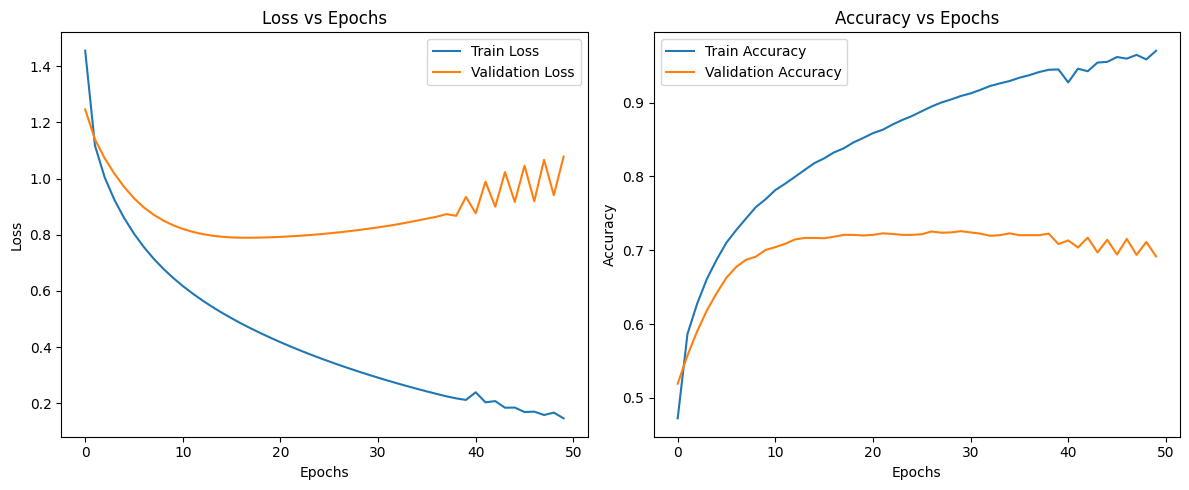

In [ ]:
# Plot training & validation history: loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Plot training & validation history: accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

- This model exhibits severe overfitting. The training loss decreases steadily, but the validation loss initially declines before rising again after 15 epochs, indicating that the model is no longer generalizing well. Similarly, the training accuracy continues to increase up to 95%, while validation accuracy plateaus around 75% and fluctuates. This suggests that the model is failing to perform well on unseen data.
- To combat overfitting, we can use techniques such as early stopping, dropout, regularization (L2 penalty), and data augmentation. Also, we might benefit from reducing model complexity if a simpler model would work better with this relatively small GTZAN dataset. Lastly, experimenting with lower learning rates and different optimisers such as Momentum and Adam might help achieve higher validation accuracy.

## P1.2
The goal is to train a CNN-RNN based classifier on the Mel spectrograms to predict the corresponding music genres. We first reduce the dimensionality of our dataset.

## Data Preparation

In [10]:
batch_size = 128

def reduce_dimension(x, y):
  return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

train_dataset_squeeze_batch = train_dataset_squeeze.batch(batch_size)
val_dataset_squeeze_batch = val_dataset_squeeze.batch(batch_size)

We perform a necessary conversion such that the CNN output can be processed by the LSTM layers.

In [8]:
cnn_rnn_model = models.Sequential([
    Input(shape=(80, 80)),

    layers.Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=6, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.LSTM(128, return_sequences=True),
    layers.LSTM(32, return_sequences=False),

    layers.Dense(200, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

cnn_rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 80, 8)               │           2,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 40, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 40, 6)               │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 20, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 20, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │           6,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           1,608 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,654 (393.18 KB)

 Trainable params: 100,654 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
cnn_rnn_model.compile(optimizer=tf.keras.optimizers.SGD(),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])

history_cnn_rnn = cnn_rnn_model.fit(train_dataset_squeeze_batch,
                            epochs=50,
                            validation_data=val_dataset_squeeze_batch,
                            verbose=1)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 400ms/step - accuracy: 0.1502 - loss: 2.0776 - val_accuracy: 0.2267 - val_loss: 2.0624
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2296 - loss: 2.0507 - val_accuracy: 0.2387 - val_loss: 2.0221
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2540 - loss: 2.0040 - val_accuracy: 0.2671 - val_loss: 1.9702
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2480 - loss: 1.9482 - val_accuracy: 0.2583 - val_loss: 1.9229
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2598 - loss: 1.8994 - val_accuracy: 0.2667 - val_loss: 1.8866
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2762 - loss: 1.8617 - val_accuracy: 0.2683 - val_loss: 1.8589
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2792 - loss: 1.8349 - val_accuracy: 0.2983 - val_loss: 1.8368
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2854 - loss: 1.8139 - val_accuracy: 0.3133 -

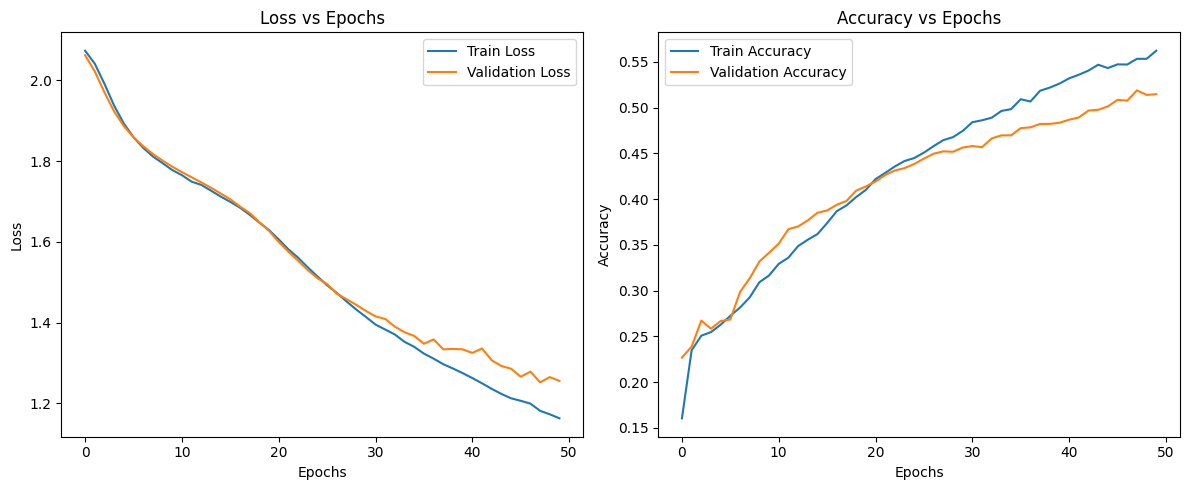

In [12]:
# Plot training & validation history: loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_rnn.history['loss'], label='Train Loss')
plt.plot(history_cnn_rnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Plot training & validation history: accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

- Both the training and validation loss decrease steadily over the epochs, suggesting that the model is learning. Until approximately 30 epochs, both losses overlap well, indicating that there is good generalisation on the validation set. However, after 30 epochs, we notice larger fluctuations in validation loss while the training loss continues to decline - this showcases overfitting. For accuracy, we notice similar overfitting where the training accuracy continues to increase but the validation accuracy plateaus around 50%. In the earlier epochs, although the two accuracy measures are well-aligned, there is a small sign of underfitting between epochs 10 - 20.
- We should consider upgrading and tuning the CNN and RNN layers to ensure sufficient model complexity for the dataset. Meanwhile, we should continue to look at measures to combat overfitting in general, with regularization (early stopping, L2 penalty, dropout).

# P2: Achieving higher accuracy


## Auxilliary Functions

### Defining Optimisers and Model Training

In [ ]:
# Mini-batch optimizer names & list
optimizer_names = ['SGD','RMSprop','Momentum','Adam']
learning_rate = 0.001

optimizer_list = [
    tf.keras.optimizers.SGD(learning_rate=learning_rate),      # Gradient Descent
    tf.keras.optimizers.RMSprop(learning_rate=learning_rate),  # RMSProp
    tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True), # SGD with momentum and Nesterov acceleration
    tf.keras.optimizers.Adam(learning_rate=learning_rate)      # Adam
]

In [ ]:
def train_model(model, model_name='model'):
    # Arrays to store training and validation performance
    hist_acc_nn = []
    hist_val_acc_nn = []
    hist_loss_nn = []
    hist_val_loss_nn = []

    # Iterate over optimizers and train the network
    for item, name in zip(optimizer_list, optimizer_names):
        print("-----------------------------")
        print(f"Doing {name} optimizer")
        print("-----------------------------")

        # Compile model with the optimizer
        model.compile(optimizer=item, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        history = model.fit(train_dataset_batch,
                            epochs=n_epochs,
                            validation_data=val_dataset_batch,
                            verbose=1)

        # Store the performance
        hist_acc_nn.append(history.history['accuracy'])
        hist_val_acc_nn.append(history.history['val_accuracy'])
        hist_loss_nn.append(history.history['loss'])
        hist_val_loss_nn.append(history.history['val_loss'])

        print("-----------------------------")

    # Prepare data for DataFrame
    data_dict = {
        "Epoch": [],
        "Optimizer": [],
        "Train_Accuracy": [],
        "Val_Accuracy": [],
        "Train_Loss": [],
        "Val_Loss": []
    }

    for i, optimizer_name in enumerate(optimizer_names):
        for epoch in range(n_epochs):  # Only loop over available epochs
            data_dict["Epoch"].append(epoch + 1)
            data_dict["Optimizer"].append(optimizer_name)
            data_dict["Train_Accuracy"].append(hist_acc_nn[i][epoch])
            data_dict["Val_Accuracy"].append(hist_val_acc_nn[i][epoch])
            data_dict["Train_Loss"].append(hist_loss_nn[i][epoch])
            data_dict["Val_Loss"].append(hist_val_loss_nn[i][epoch])

    # Convert the dictionary into a DataFrame
    df = pd.DataFrame(data_dict)
    csv_filename = f"{model_name}.csv"
    df.to_csv(csv_filename, index=False)

    print(f"Training history saved to '{csv_filename}'")
    return df

### Plot train & validation, accuracy & loss

In [ ]:
def optimiser_result_plots(csv_file):
  df = pd.read_csv(csv_file)

  # Create subplots: 4 plots for Train Accuracy, Train Loss, Val Accuracy, Val Loss
  fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
  axes = axes.flatten()

  # Titles and column mappings
  metrics = {
      "Train Accuracy": "Train_Accuracy",
      "Train Loss": "Train_Loss",
      "Validation Accuracy": "Val_Accuracy",
      "Validation Loss": "Val_Loss"
  }

  # Plot each metric
  for ax, (title, col_name) in zip(axes, metrics.items()):
      for optimizer in optimizer_names:
          df_opt = df[df["Optimizer"] == optimizer]
          ax.plot(df_opt["Epoch"], df_opt[col_name], label=optimizer)

      ax.set_title(title)
      ax.set_xlabel("Epoch")
      ax.set_ylabel(title.split()[1])  # Use 'Accuracy' or 'Loss'
      ax.legend()
      ax.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
def loss_acc_plots(csv_file):
    df = pd.read_csv(csv_file)

    # Filter for only the Momentum optimizer
    df_momentum = df[df["Optimizer"] == "Momentum"]

    # Create subplots: Loss and Accuracy
    plt.figure(figsize=(12, 5))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(df_momentum["Epoch"], df_momentum["Train_Loss"], label="Train Loss")
    plt.plot(df_momentum["Epoch"], df_momentum["Val_Loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs Epochs")
    plt.grid(True)

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(df_momentum["Epoch"], df_momentum["Train_Accuracy"], label="Train Accuracy")
    plt.plot(df_momentum["Epoch"], df_momentum["Val_Accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## CNN Architectures

### Wider, Deeper Parallel CNN: varying filter sizes to learn more detailed frequency patterns with batch normalisation and dropout for better generalisation

The model has three parallel branches with different convolutional filter sizes to capture musical features at multiple levels of granularity. Each branch specialises in detecting patterns at different resolutions, improving feature extraction.

1. Branch 1 (Broad Patterns): Uses large 8x8 filters to capture broad frequency structures. filters to capture broad harmonic structures and large-scale features. Max pooling with 4x4 window ensures strong downsampling, reducing redundant information.
2. Branch 2 (Finer Details): Uses 4x4 filters to extract finer musical textures and rhythmic structures. Smaller max pooling window 2x2 preserves more detailed information.
3. Branch 3 (Small Receptive Fields): Uses 2x2 filters to focus on fine-grained details, e.g. timbre or dynamics in spectrograms.

We also apply batch normalisation to each branch to stabilise learning, and then concatenate the branches. A dense layer with 256 neurons learns complex non-linear combinations of the extracted features, while a dropout (0.3) layer prevents overfitting by randomly deactivating neurons during training.

In [ ]:
# Define input layer
input_layer = layers.Input(shape=(80, 80, 1))

# First parallel branch (captures broad patterns)
branch_1 = layers.Conv2D(32, (8,8), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(input_layer)
branch_1 = layers.Conv2D(64, (8,8), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(branch_1)
branch_1 = layers.MaxPooling2D(pool_size=(4,4))(branch_1)
branch_1 = layers.BatchNormalization()(branch_1)
branch_1 = layers.Flatten()(branch_1)

# Second parallel branch (captures finer details)
branch_2 = layers.Conv2D(32, (4,4), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(input_layer)
branch_2 = layers.Conv2D(64, (4,4), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(branch_2)
branch_2 = layers.MaxPooling2D(pool_size=(2,2))(branch_2)
branch_2 = layers.BatchNormalization()(branch_2)
branch_2 = layers.Flatten()(branch_2)

# Third parallel branch (even smaller receptive fields)
branch_3 = layers.Conv2D(16, (2,2), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(input_layer)
branch_3 = layers.Conv2D(32, (2,2), padding="same", activation=tf.keras.layers.LeakyReLU(0.3))(branch_3)
branch_3 = layers.MaxPooling2D(pool_size=(2,2))(branch_3)
branch_3 = layers.BatchNormalization()(branch_3)
branch_3 = layers.Flatten()(branch_3)

# Merge all branches
merged_branch = layers.Concatenate()([branch_1, branch_2, branch_3])

# Fully connected layers
dense_layer = layers.Dense(256, activation="relu")(merged_branch)
dropout_layer = layers.Dropout(0.3)(dense_layer)
output_layer = layers.Dense(8, activation="softmax")(dropout_layer)  # 8 genres

wide_parallel_cnn = models.Model(inputs=input_layer, outputs=output_layer)
wide_parallel_cnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 80, 80, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 80, 80, 32)     │          2,080 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 80, 80, 32)     │            544 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 80, 80, 16)     │             80 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 80, 80, 64)     │        131,136 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 80, 80, 64)     │         32,832 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 80, 80, 32)     │          2,080 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 20, 20, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 40, 40, 64)     │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 40, 40, 32)     │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 20, 20, 64)     │            256 │ max_pooling2d_6[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 40, 40, 64)     │            256 │ max_pooling2d_7[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 40, 40, 32)     │            128 │ max_pooling2d_8[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 25600)          │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 102400)         │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 51200)          │              0 │ batch_normalization_8… │
├──────────────────────

 Total params: 46,046,904 (175.65 MB)

 Trainable params: 46,046,584 (175.65 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
wide_parallel_cnn_df = train_model(wide_parallel_cnn, model_name="wide_parallel_cnn")

-----------------------------
Doing SGD optimizer
-----------------------------
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.4632 - loss: 1.7195 - val_accuracy: 0.4671 - val_loss: 1.6515
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.7128 - loss: 0.7965 - val_accuracy: 0.5462 - val_loss: 1.4370
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.7962 - loss: 0.5951 - val_accuracy: 0.6725 - val_loss: 1.1638
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.8413 - loss: 0.4776 - val_accuracy: 0.7271 - val_loss: 0.9545
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.8732 - loss: 0.3991 - val_accuracy: 0.7429 - val_loss: 0.8125
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9011 - loss: 0.3358 - val_accuracy: 0.7646 - val_loss: 0.7145
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.9174 - loss: 0.2924 - val_accuracy: 0.7817 - val_loss: 0.6410
Epoch 8/50
75/75 

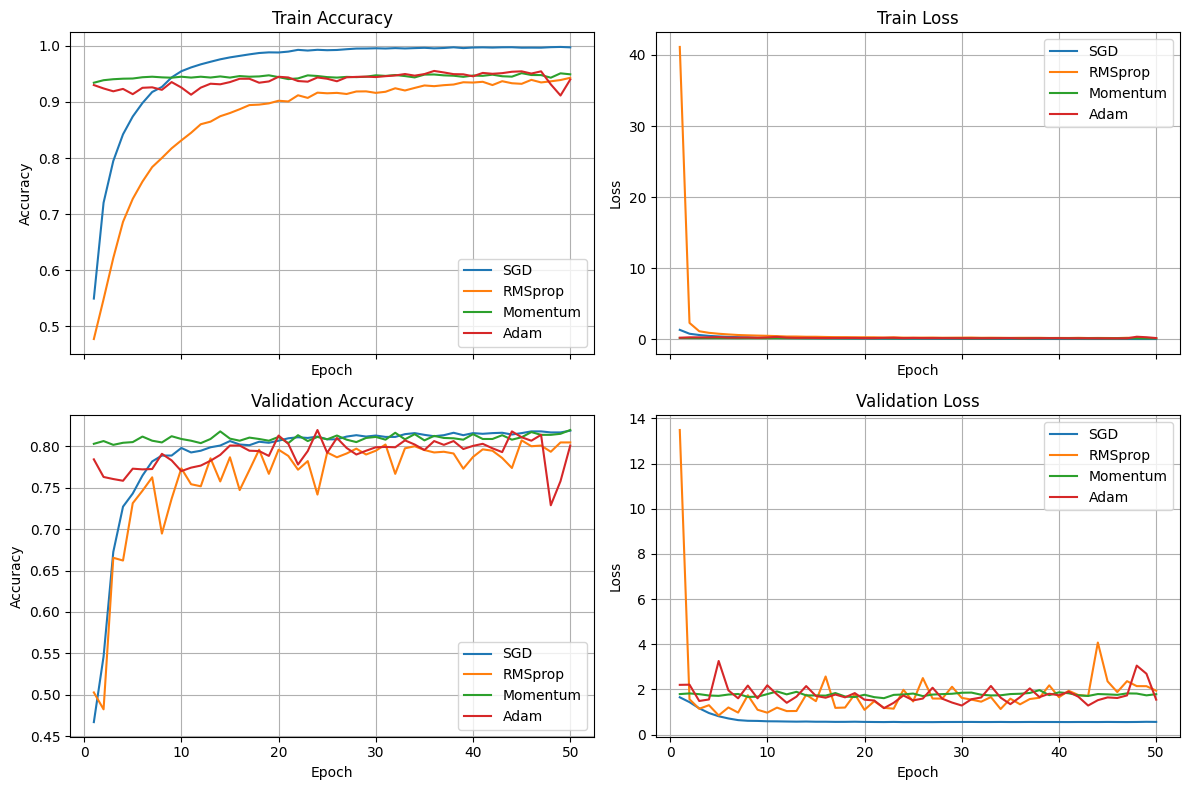

In [ ]:
optimiser_result_plots("wide_parallel_cnn.csv")

- While this parallel CNN model did not achieve the desired 85% target on the validation accuracy, we still present the graphs to showcase the various optimisers. We can conclude that Momentum with a learning rate of 0.001 is the most stable and high-performing optimiser that maximises validation accuracy and minimises overfitting by having the minimal gap between train and validation accuracy. From now on, we will only consider our models with Momentum optimiser.
- As for improvements on the parallel CNN structure itself, increasing filter sizes and depth in the broader-pattern branch (128 filters in deeper layers) may help extract features better. Also, it could be the case that an LSTM or GRU layer is required after merging branches to capture temporal dependencies; perhaps the spatial dependencies captured by the CNNs alone are insufficient for modelling the GTZAN dataset.

### ResNet-50
To consider an alternate CNN architecture, I tried to implement a ResNet-50 model on the processed GTZAN dataset, by switching the weights to "None" instead of ImageNet, such that the ResNet model is trained from scratch. This architectural choice was made because while spectrograms visually resemble images, they represent a time-frequency transformation of audio data; different from the natural images that ImageNet weights are trained on. However, this model had very poor training and validation performance on the dataset, with validation accuracy around 25% even at the 50th epoch. This could be because ResNet-50 was originally designed for natural image classification, not to capture temporal / sequential patterns found in audio data. I did try transfer learning using ImageNet weights, but as expected the model still struggled because audio features and patterns differen from the features found in natural images.

## RNN Architectures
I tried LSTM and BiLSTM as a standalone RNN architectures (not combined with CNN), but their performance plateaued at 50-60% accuracy on the GTZAN dataset. I believe the main reason is because the GTZAN dataset originally consists of 30-second audio clips for each song; but since we use preprocessed Mel spectrograms in which each song has been divided into 15 segments, the final duration of each audio segment in the dataset is 2 seconds. Given this short duration of the spectrogram, it may not give LSTM enough temporal context to extract meaningful temporal dependencies from the data; it is typically better learned over longer sequences. It could also be that spatial features are more relevant for genre classification than temporal classification.

## CNN + RNN Architectures
We tried 3 hybrid models that combine CNNs for spatial feature extraction with RNNs (like LSTM or GRU) for any remaining temporal dependencies might offer better performance by capturing both the spatial and temporal aspects of the data. Note that Conv1D is traditionally used for sequential data in CNN + RNN architectures, to capture patterns along the time dimension. However, by replacing Conv1D with Conv2D, it gave me better results because our input data, spectrograms, are not just sequential data but also spatial data (frequencies). Hence, Conv2D allowed for better capturing of both spatial and time relationships, and we proceed with that from now on for our model architectures below, and reshape the output from the CNN accordingly from 3D output to 2D input for the RNN models shown below.
1. CNN + BiLSTM
2. Data Augmented CNN + GRU
3. CNN + GRU

### CNN + BiLSTM
1. Convolutional Layers (Feature Extraction): The 3 convolutional layers followed by max pooling and batch normalisation help capture varying levels of non-redundant, spatial frequency patterns without overfitting.
2. Reshaping for LSTM Input: The output from the CNN is reshaped to (10, 640), treating the time axis (10) as sequence steps for LSTMs.
3. Bidirectional LSTM Layers (Temporal Feature Learning): captures temporal dependencies in both forward and backward direction - by considering both the past and future musical context.
4. Fully Connected Layers: to learn complex feature interactions, followed by dropout layer to reduce dimensionality and prevent overfitting.

In [ ]:
cnn_rnn_model_2 = models.Sequential([
    Input(shape=(80, 80, 1)),

    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output for LSTM input
    layers.Reshape((10, 640)),

    # Bidirectional LSTM layers
    layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(256, return_sequences=False)),

    # Fully connected layers
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation="softmax")
])

cnn_rnn_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 80, 80, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 40, 40, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 1024)            │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,424,136 (32.14 MB)

 Trainable params: 8,423,912 (32.13 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
train_model(cnn_rnn_model_2, "cnn_rnn_model_2")

-----------------------------
Doing SGD optimizer
-----------------------------
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.1343 - loss: 2.0801 - val_accuracy: 0.1250 - val_loss: 2.0775
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.2084 - loss: 2.0320 - val_accuracy: 0.1304 - val_loss: 2.0690
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2793 - loss: 1.9886 - val_accuracy: 0.2188 - val_loss: 2.0412
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.3023 - loss: 1.9519 - val_accuracy: 0.2758 - val_loss: 1.9944
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3334 - loss: 1.9204 - val_accuracy: 0.3308 - val_loss: 1.9365
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.3405 - loss: 1.8882 - val_accuracy: 0.3658 - val_loss: 1.8815
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3506 - loss: 1.8589 - val_accuracy: 0.3862 - val_loss: 1.8388
Epoch 8/50
75/75 ━━━━━━━━━━━━

,Epoch,Optimizer,Train_Accuracy,Val_Accuracy,Train_Loss,Val_Loss
0,1,SGD,0.153021,0.125000,2.066564,2.077533
1,2,SGD,0.223750,0.130417,2.021587,2.069036
2,3,SGD,0.282396,0.218750,1.981852,2.041220
3,4,SGD,0.302604,0.275833,1.946476,1.994450
4,5,SGD,0.330104,0.330833,1.914988,1.936452
...,...,...,...,...,...,...
195,46,Adam,0.998438,0.825833,0.005047,1.188145
196,47,Adam,0.996667,0.875000,0.007787,0.923092
197,48,Adam,0.991562,0.836250,0.032782,0.993479
198,49,Adam,0.994583,0.830833,0.015946,1.105696


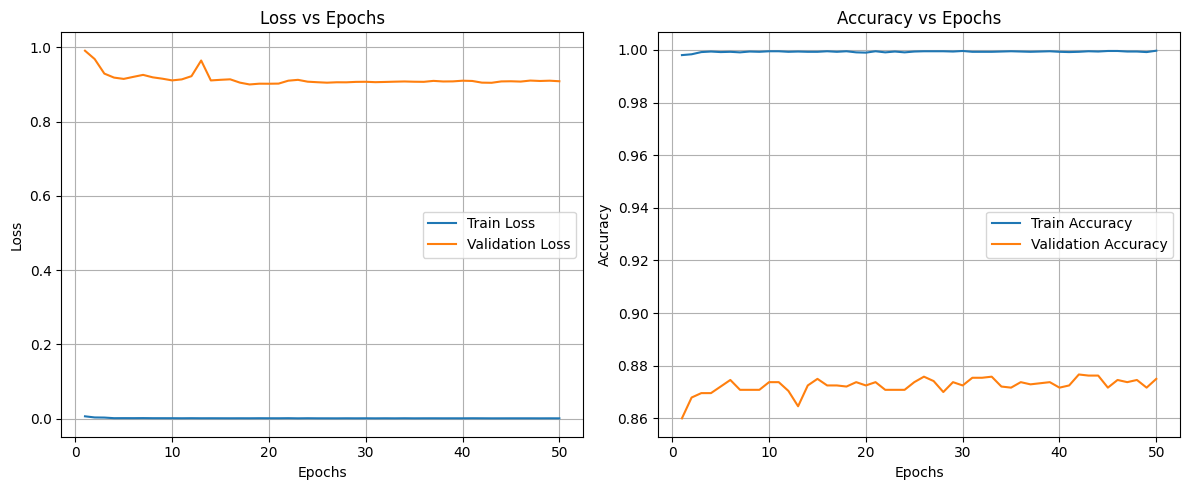

In [ ]:
loss_acc_plots("cnn_rnn_model_2.csv")

Typically, BiLSTM learns dependencies from both past and future context, which helps in genre classification where musical elements have long-range dependencies. Therefore my initial hypothesis was that this model would not perform too well, since the spectrograms only represent short-range, 2-second audio clips. Regardless BiLSTM performed better than a CNN + LSTM model I tried earlier, showcasing that there is some value in learning both the forward and backward musical trends. The validation accuracy lies between 86-87%, demonstrating slight overfitting given that the training accuracy is close to perfect. Similarly for the loss per epoch, the validation loss plateaus below 1 for validation set, but is close to 0 for the training set. This suggests that although the model is good at capturing patterns from the dataset due to the high accuracy, it could benefit from a slight model simplication or better measures to combat overfitting such as a higher dropou rate, L2 regularisation or data augmentation.

### Data Augmented CNN + GRU
**Model architecture:**
- In terms of model architecture, we use the same layout as CNN + BiLSTM model, except we replace the 2 BiLSTM layers with 2 GRU layers. We consider GRU because GRUs are similar to LSTMs but with fewer parameters because they use fewer gates. This makes GRUs faster to train and more efficient, especially with small or noisy datasets like GTZAN. The faster converge and computational efficient can result in better performance in terms of accuracy, especially for smaller datasets like GTZAN.

**Data Augmentation**
- We attempted to incorporate data augmentation as a method to introduce variability to the spectrogram data and thereby enhance model generalisation. RandomTranslation(0.1, 0.1) simulates slight shifts in time and frequency, while RandomZoom(0.1) applies small zooming effects, altering the spectrogram's scale to make the model robust to frequency distortions. Gaussian Noise adds random noise with a mean of 0 and a small standard deviation (0.01), preventing over-reliance on specific music features. Random Contrast (0.8, 1.2) varies the contrast of the spectrogram. Overall, these methods are meant to mimick real-world variations in musical recordings and thus help the model becomre more robust, reducing the risk of overfitting.
- Unfortunately, data augmentation was giving worse accuracy results for all models that I have tried, other than CNN + GRU which is presented below. This could be due to overly distorted features or insufficient training for the additional variability added in the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomTranslation(0.1, 0.1),  # Time shifting
    layers.RandomZoom(0.1),  # Spectrogram distortions
    layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)),  # Gaussian Noise
    layers.Lambda(lambda x: tf.image.stateless_random_contrast(x, 0.8, 1.2, seed=(1, 2)))  # Random Contrast
])

In [ ]:
cnn_rnn_aug_3 = models.Sequential([
    Input(shape=(80, 80, 1)),

    # Apply data augmentation
    data_augmentation,

    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output for GRU input
    layers.Reshape((10, 640)),

    # GRU layers
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=False),

    # Fully connected layers
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation="softmax")
])

cnn_rnn_aug_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 80, 80, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80, 80, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 10, 512)             │       1,772,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         591,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,179,720 (12.13 MB)

 Trainable params: 3,179,496 (12.13 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
train_model(cnn_rnn_aug_3, "cnn_rnn_aug_3")

-----------------------------
Doing SGD optimizer
-----------------------------
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.1244 - loss: 2.1450 - val_accuracy: 0.1375 - val_loss: 2.0729
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1662 - loss: 2.0370 - val_accuracy: 0.1671 - val_loss: 2.0546
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2341 - loss: 1.9585 - val_accuracy: 0.2354 - val_loss: 2.0033
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3154 - loss: 1.8862 - val_accuracy: 0.2917 - val_loss: 1.9206
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3455 - loss: 1.8398 - val_accuracy: 0.3650 - val_loss: 1.8352
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3548 - loss: 1.8032 - val_accuracy: 0.3896 - val_loss: 1.7692
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.3726 - loss: 1.7610 - val_accuracy: 0.3950 - val_loss: 1.7287
Epoch 8/50
75/75 ━━━━━━━━━━━━

,Epoch,Optimizer,Train_Accuracy,Val_Accuracy,Train_Loss,Val_Loss
0,1,SGD,0.134583,0.137500,2.110658,2.072882
1,2,SGD,0.183854,0.167083,2.010821,2.054615
2,3,SGD,0.255417,0.235417,1.938389,2.003267
3,4,SGD,0.325833,0.291667,1.874636,1.920635
4,5,SGD,0.348229,0.365000,1.831284,1.835158
...,...,...,...,...,...,...
195,46,Adam,0.977917,0.858750,0.066917,0.576521
196,47,Adam,0.975833,0.864167,0.076874,0.643648
197,48,Adam,0.979167,0.860000,0.065297,0.606060
198,49,Adam,0.979062,0.875000,0.062703,0.526766


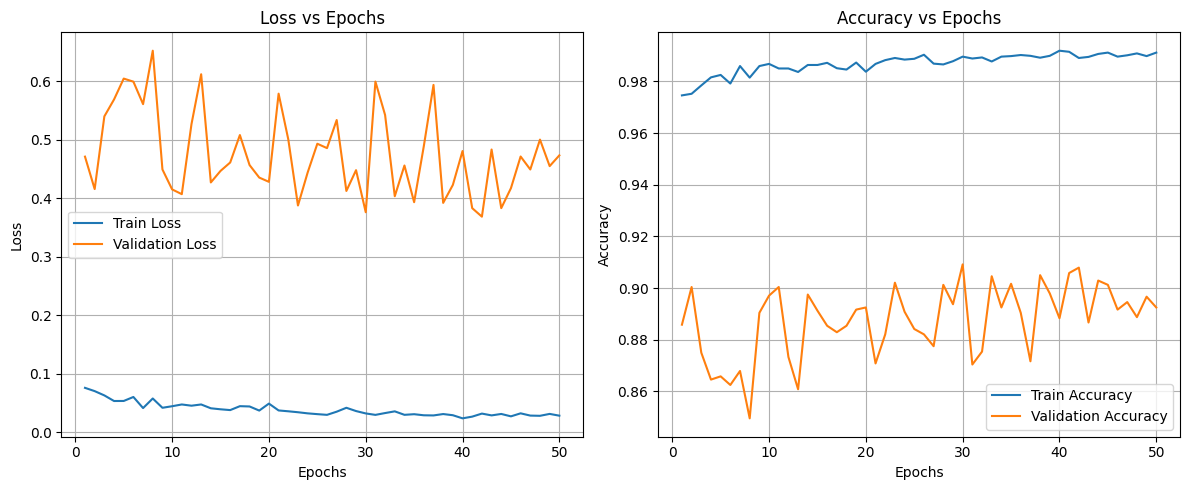

In [ ]:
loss_acc_plots("cnn_rnn_aug_3.csv")

The fluctuation in validation accuracy (86-90% per epoch) when using data augmentation comes from increased training data variability, making it harder for the model to settle into a stable learning pattern. Augmentation introduces random transformations (time stretching, Gaussian noise, brightness adjustment) to the dataset, forcing the model to generalise better but also causing performance inconsistency across epochs. While this prevents overfitting and enhances generalization, it also leads to sensitivity towards the augmented samples. We prefer a more stable model, because it ensures dependable performance across the epochs, even at the cost of a slight decrease in validation accuracy.

### CNN + GRU
The same model architecture as above, except we do not add data augmentation.

In [ ]:
cnn_rnn_model_3 = models.Sequential([
    Input(shape=(80, 80, 1)),

    layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output for GRU input
    layers.Reshape((10, 640)),

    # GRU layers
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=False),

    # Fully connected layers
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation="softmax")
])

cnn_rnn_model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 80, 80, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 40, 40, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 10, 640)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 10, 512)             │       1,772,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 256)                 │         591,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,179,720 (12.13 MB)

 Trainable params: 3,179,496 (12.13 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
train_model(cnn_rnn_model_3, "cnn_rnn_model_3")

-----------------------------
Doing SGD optimizer
-----------------------------
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.1410 - loss: 2.0885 - val_accuracy: 0.1900 - val_loss: 2.0716
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2346 - loss: 1.9985 - val_accuracy: 0.2479 - val_loss: 2.0405
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2951 - loss: 1.9262 - val_accuracy: 0.2696 - val_loss: 1.9704
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3279 - loss: 1.8717 - val_accuracy: 0.3013 - val_loss: 1.8831
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3541 - loss: 1.8191 - val_accuracy: 0.3467 - val_loss: 1.8047
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3764 - loss: 1.7744 - val_accuracy: 0.3971 - val_loss: 1.7424
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3940 - loss: 1.7332 - val_accuracy: 0.4275 - val_loss: 1.6913
Epoch 8/50
75/75 ━━━━━━━━━━━━

,Epoch,Optimizer,Train_Accuracy,Val_Accuracy,Train_Loss,Val_Loss
0,1,SGD,0.155417,0.190000,2.066162,2.071636
1,2,SGD,0.258229,0.247917,1.979684,2.040475
2,3,SGD,0.311250,0.269583,1.911444,1.970402
3,4,SGD,0.335833,0.301250,1.858864,1.883085
4,5,SGD,0.357083,0.346667,1.810249,1.804701
...,...,...,...,...,...,...
195,46,Adam,0.994687,0.842083,0.014794,1.175912
196,47,Adam,0.987917,0.862083,0.044163,0.869869
197,48,Adam,0.990208,0.865000,0.035934,0.785818
198,49,Adam,0.992188,0.830417,0.026266,1.190289


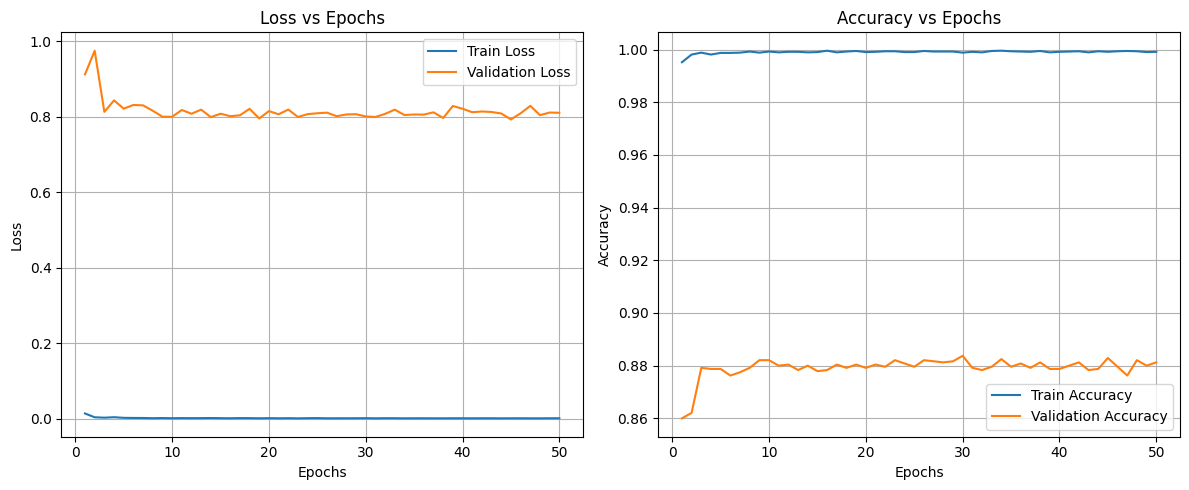

In [ ]:
loss_acc_plots("cnn_rnn_model_3.csv")

This model has the most stable and best validation accuracy we have encountered, 86-88.5%, and also demonstrates the least amount of overfitting in comparison to the other models we have showcased above. This is evident in the validation loss plateauing at 0.8 instead of 1, and in the smaller gap between training and validation accuracy. To improve generalisation, we could consider further increasing the regularisation, and implementing techniques like early stopping or batch normalisation.

# **BEST MODEL: CNN + RNN (GRU) - VALIDATION ACCURACY: 86-88.5%**